In [2]:
%load_ext autoreload
%autoreload 2
import os, sys
os.environ["OMP_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 

In [3]:
os.path.isdir

<function genericpath.isdir(s)>

In [4]:
import socket
hostname = socket.gethostname()
print(hostname)

Lucrezias-MacBook-Pro.local


In [5]:
if hostname == 'Lucrezias-MacBook-Pro.local':
	print('On local laptop')
	package_dir ='/Users/Lucrezia/Library/CloudStorage/OneDrive-UniversityCollegeLondon/postdoc/code/lucrezia-dlp-cna'
	funnel_path = '/Users/lucrezia/Library/CloudStorage/OneDrive-UniversityCollegeLondon/postdoc/funnel_data'
	wd = '/Users/lucrezia/Library/CloudStorage/OneDrive-UniversityCollegeLondon/postdoc/'
else:
	package_dir = '/camp/home/patrunl/home/working/patrunl/single_cell_dlp/lucrezia-dlp-cna'
	funnel_path = '/nemo/project/proj-tracerx-lung/tctProjects/zaccariaLab/ccg_lab/datasets/Funnell2022'
	wd = '/camp/home/patrunl/home/working/patrunl/single_cell_dlp/'	

On local laptop


In [6]:
import pandas as pd
import os
import numpy as np
import random
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append(f'{package_dir}/src')
from read_data_utils import *
from simulations_utils import *
import pickle

from scipy.spatial.distance import hamming

sys.path.append(f'{package_dir}/hmmcopy_comparison')

# import massey
import hmmcopy_NBcomparison

In [7]:
def compute_data_hmmcopy(cells_profiles):
	hmmcopy_data = cells_profiles[['cell_id', 'chr', 'start', 'end', 'total_reads', 'tot_CN']].rename({'total_reads' : 'reads'}, axis = 1)
	hmmcopy_data['gc'] = 0.5
	hmmcopy_data['map'] = 1
	hmmcopy_data['width'] = hmmcopy_data['end'] - hmmcopy_data['start']
	# in https://github.com/shahcompbio/single_cell_pipeline/blob/master/single_cell/workflows/hmmcopy/scripts/correct_read_count.py
	# they do:
	# df['copy'] = df['modal_corrected']
	# df['copy'][df['map'] < self.mappability] = float('NaN')
	# df = df.rename(columns=({"modal_corrected": "cor_gc"}))
	# In order to obtain the modal_corrected column, they run the following command:
	#  df_regression['modal_corrected'] = df_regression['reads'] / df_regression[modal_quantile]
	# and the modal_curve column is a copy of the modal_quantile
	# and modal quantile is one value per cell. I can change this dividing the reads by the median reads in the cell.
	hmmcopy_data['modal_quantile'] = hmmcopy_data.groupby('cell_id')['reads'].transform('median')
	print(hmmcopy_data['modal_quantile'].unique())
	hmmcopy_data['cor_map'] = np.nan
	hmmcopy_data['valid'] = True
	hmmcopy_data['cor_gc'] = hmmcopy_data['reads'] / hmmcopy_data['modal_quantile']
	hmmcopy_data['copy'] = hmmcopy_data['cor_gc']
	hmmcopy_data['ideal'] = True
	hmmcopy_data['modal_curve'] = np.nan

	# hmmcopy_data = hmmcopy_data[hmmcopy_data['reads'] > 20]

	return hmmcopy_data

	# chr,start,end,width,gc,map,reads,valid,ideal,modal_quantile,modal_curve,cor_gc,copy,cor_map


## Set parameters for simulations

coordinates must be one of 'arms' (segments coorespond to chromosome arms), 'real_segments' (breakpoint coordinates are taken from a real funnel dataset) and 'random' (breakpoints are assigned ranomly, mimicking the length observed in Funnel)

In [8]:
output_directory = "simulations"
os.makedirs(output_directory, exist_ok=True)

os.chdir(f'{wd}/funnel_data/')

In [9]:

clones = pd.read_csv(f'{funnel_path}/signatures_dataset/DLP/CNA/hscn_clones.csv.gz')
clones['ploidy'] = clones.groupby(['patient', 'clone_id'])['state'].transform('mean')


In [10]:
from compute_cnv_hmm import compute_segment_id


clones['segment_id'] = clones.groupby(['patient', 'clone_id'], group_keys=False)['state'].apply(lambda x: compute_segment_id(x))
clones['aneuploidy'] = clones['state'] != clones['ploidy'].round()
clones['length'] = clones['end'] - clones['start']
clones['patient_clone'] = clones['patient'] + '_' + clones['clone_id'].astype(str)

In [11]:

# Assuming clones is your DataFrame and you want to group by 'patient' and 'clone_id'
# Define a function that returns a DataFrame with two columns
def custom_function(group):
    return pd.DataFrame({
        'LOH_fraction': [(group['LOH'] == 'LOH').sum() / group.shape[0]],
        'perc_aneuploidy': [(group['aneuploidy'] * group['length']).sum() / group['length'].sum()],
        'nbreakpoints' : [group['segment_id'].nunique()]
    })

# Apply the custom function to each group
summary = clones.groupby(['patient', 'clone_id', 'ploidy', 'patient_clone']).apply(custom_function).reset_index(drop=False)

summary

/var/folders/zt/dj1f6gpj4251dffyhx1l94cm0000gn/T/ipykernel_2713/146426646.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = clones.groupby(['patient', 'clone_id', 'ploidy', 'patient_clone']).apply(custom_function).reset_index(drop=False)


,patient,clone_id,ploidy,patient_clone,level_4,LOH_fraction,perc_aneuploidy,nbreakpoints
0,DG1134,A,4.737473,DG1134_A,0,0.149992,0.719238,113
1,DG1134,B,5.404633,DG1134_B,0,0.155085,0.893872,89
2,DG1134,C,2.816658,DG1134_C,0,0.198291,0.612946,80
3,DG1134,D,3.367340,DG1134_D,0,0.103992,0.707574,171
4,DG1134,E,4.495811,DG1134_E,0,0.153277,0.751437,189
...,...,...,...,...,...,...,...,...
242,SA906b,F,2.022671,SA906b_F,0,0.003286,0.029243,9
243,SA906b,G,1.989157,SA906b_G,0,0.015443,0.020043,6
244,SA906b,H,2.002136,SA906b_H,0,0.002464,0.007064,4
245,SA906b,I,2.045178,SA906b_I,0,0.008379,0.061935,9


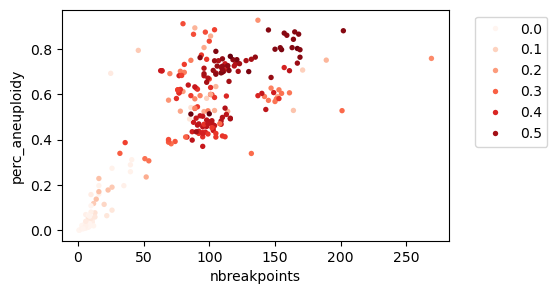

In [12]:
plt.figure(figsize = (5,3))
sns.scatterplot(x = 'nbreakpoints', y = 'perc_aneuploidy', data = summary, linewidth = 0, edgecolor = 'grey', s = 15, palette = 'Reds', hue = 'LOH_fraction')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


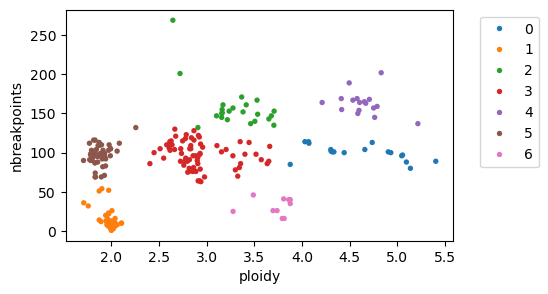

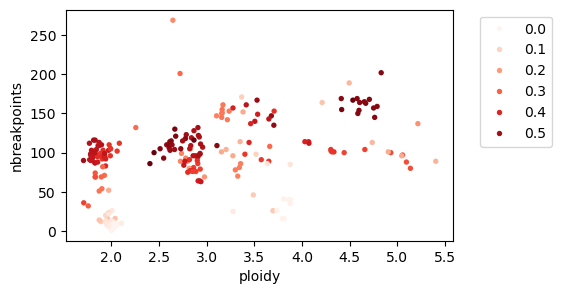

In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming 'clones' is your DataFrame
# Extract the relevant columns
X = summary[['ploidy', 'nbreakpoints']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Initialize the KMeans model
kmeans = KMeans(n_clusters=7, random_state=42)  # Adjust n_clusters as needed

# Fit the model
kmeans.fit(X_scaled)

# Add the cluster labels to the DataFrame
summary['cluster'] = kmeans.labels_

plt.figure(figsize = (5,3))
sns.scatterplot(x = 'ploidy', y = 'nbreakpoints', data = summary, 
					linewidth = 0, s = 15, hue = 'cluster', palette = 'tab10')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.figure(figsize = (5,3))
sns.scatterplot(x = 'ploidy', y = 'nbreakpoints', data = summary, 
					linewidth = 0, s = 15, hue = 'LOH_fraction', palette = 'Reds')
				
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [19]:
random.seed(1)
np.random.seed(1)

# low_low = summary[(summary['cluster'] == 6) & (summary['LOH_fraction'] < 0.2)].sample(1)
summary = summary[summary['cluster'] != 1]

sampled_clones_lowloh = summary[summary['LOH_fraction'] < 0.2].groupby('cluster').apply(lambda x: x.sample(1)).reset_index(drop=True)
sampled_clones_lowhigh = summary[summary['LOH_fraction'] > 0.2].groupby('cluster').apply(lambda x: x.sample(1)).reset_index(drop=True)
sampled_clones = pd.concat([sampled_clones_lowloh, sampled_clones_lowhigh])
sampled_clones

/var/folders/zt/dj1f6gpj4251dffyhx1l94cm0000gn/T/ipykernel_2713/1906786695.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_clones_lowloh = summary[summary['LOH_fraction'] < 0.2].groupby('cluster').apply(lambda x: x.sample(1)).reset_index(drop=True)
/var/folders/zt/dj1f6gpj4251dffyhx1l94cm0000gn/T/ipykernel_2713/1906786695.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_clones_lowhigh

,patient,clone_id,ploidy,patient_clone,level_4,LOH_fraction,perc_aneuploidy,nbreakpoints,cluster
0,SA1054,E,3.876787,SA1054_E,0,0.057500,0.491539,85,0
1,DG1134,D,3.367340,DG1134_D,0,0.103992,0.707574,171,2
2,DG1197,B,3.351240,DG1197_B,0,0.157385,0.524889,114,3
3,DG1134,F,4.211763,DG1134_F,0,0.125842,0.529161,164,4
4,SA039,G,3.276819,SA039_G,0,0.036800,0.693116,25,6
0,SA1096,F,5.096106,SA1096_F,0,0.329719,0.865615,88,0
1,SA1135,A,3.705109,SA1135_A,0,0.520453,0.764580,135,2
2,SA609,A,3.107771,SA609_A,0,0.534253,0.695088,109,3
3,SA604,F,4.831608,SA604_F,0,0.535239,0.881222,202,4
4,SA1181,A,2.060292,SA1181_A,0,0.364383,0.452932,102,5


In [20]:
clone_centroid = clones[clones['patient_clone'].isin(sampled_clones['patient_clone'].values)].copy()

clone_centroid = convert_chr_to_int(clone_centroid)

clone_centroid = compute_absolute_start(clone_centroid)
clone_centroid

,patient,clone_id,chr,start,end,state,copy,Min,Maj,alleleA,...,phase,state_phase,state_BAF,ploidy,segment_id,aneuploidy,length,patient_clone,chr_from,start_absolute
36522,SA604,F,1,1,500000.0,3,NaN,0,3,0,...,A,A-Hom,0.0,4.831608,1.0,True,499999.0,SA604_F,0.000000e+00,1.000000e+00
36523,SA604,F,1,500001,1000000.0,3,NaN,0,3,0,...,A,A-Hom,0.0,4.831608,1.0,True,499999.0,SA604_F,0.000000e+00,5.000010e+05
36524,SA604,F,1,1000001,1500000.0,3,3.192895,0,3,0,...,A,A-Hom,0.0,4.831608,1.0,True,499999.0,SA604_F,0.000000e+00,1.000001e+06
36525,SA604,F,1,1500001,2000000.0,3,3.076658,0,3,0,...,A,A-Hom,0.0,4.831608,1.0,True,499999.0,SA604_F,0.000000e+00,1.500001e+06
36526,SA604,F,1,2000001,2500000.0,3,3.586646,0,3,351,...,A,A-Hom,0.0,4.831608,1.0,True,499999.0,SA604_F,0.000000e+00,2.000001e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466962,SA1054,E,23,153000001,153500000.0,5,4.718293,3,2,0,...,B,B-Gained,0.6,3.876787,85.0,True,499999.0,SA1054_E,2.888000e+09,3.041000e+09
1466963,SA1054,E,23,153500001,154000000.0,5,4.557528,3,2,0,...,B,B-Gained,0.6,3.876787,85.0,True,499999.0,SA1054_E,2.888000e+09,3.041500e+09
1466964,SA1054,E,23,154000001,154500000.0,5,5.839899,3,2,0,...,B,B-Gained,0.6,3.876787,85.0,True,499999.0,SA1054_E,2.888000e+09,3.042000e+09
1466965,SA1054,E,23,154500001,155000000.0,5,4.614413,3,2,0,...,B,B-Gained,0.6,3.876787,85.0,True,499999.0,SA1054_E,2.888000e+09,3.042500e+09


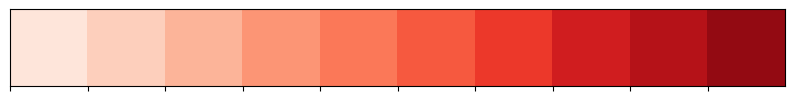

In [21]:
red_palette = sns.color_palette('Reds', 10)#[20::20]
# red_palette =  {k:sns.saturate(v) for k,v in zip([1,2,4,6,7], red_palette)}
sns.palplot(red_palette)
# sns.palplot([v for k,v in red_palette.items()])

In [22]:
tab20_palette = sns.color_palette("RdBu", 10)

# Create a dictionary mapping integers from 0 to 19 to colors in the tab20 palette
color_mapping = {i+2: red_palette[i] for i in range(0,10)}
color_mapping[0] = '#4393c3'
color_mapping[1] = '#92c5de'
# color_mapping = {0: '#4393c3', 1: '#92c5de', 2 :'#f7f7f7', 3 : '#fddbc7', 4 : '#f4a582', 5 : '#d6604d', 6 : '#b2182b', 7 : '#67001f'}

paired_palette = sns.color_palette("Paired", 25)
color_mapping = {i: paired_palette[i] for i in range(0,25)}

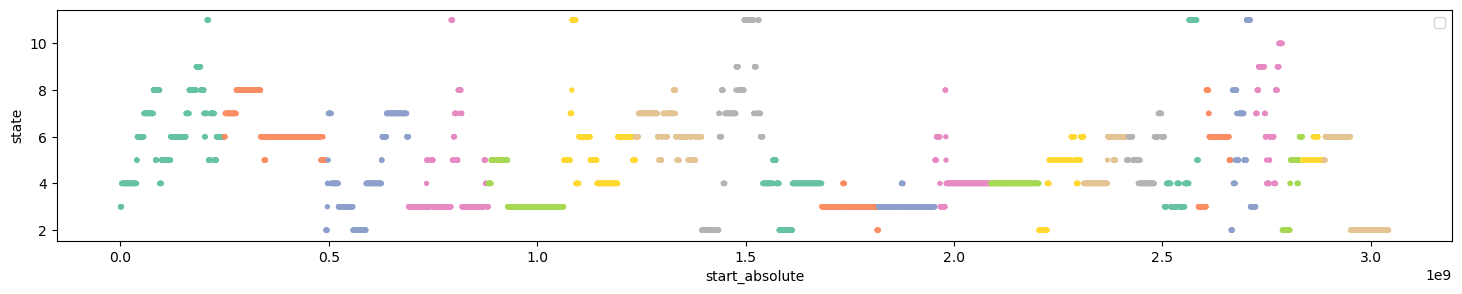

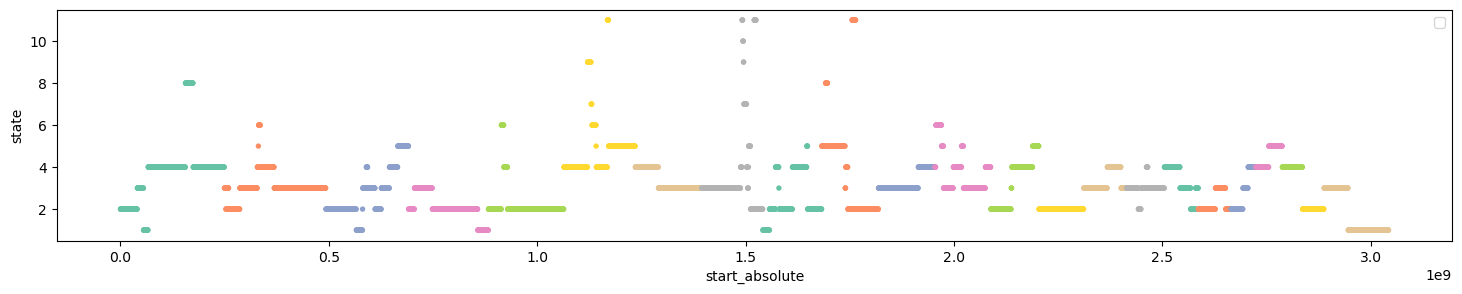

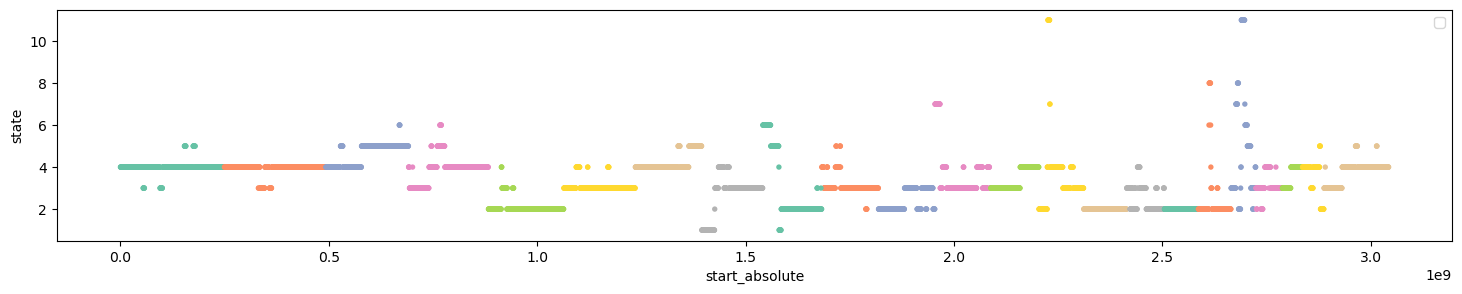

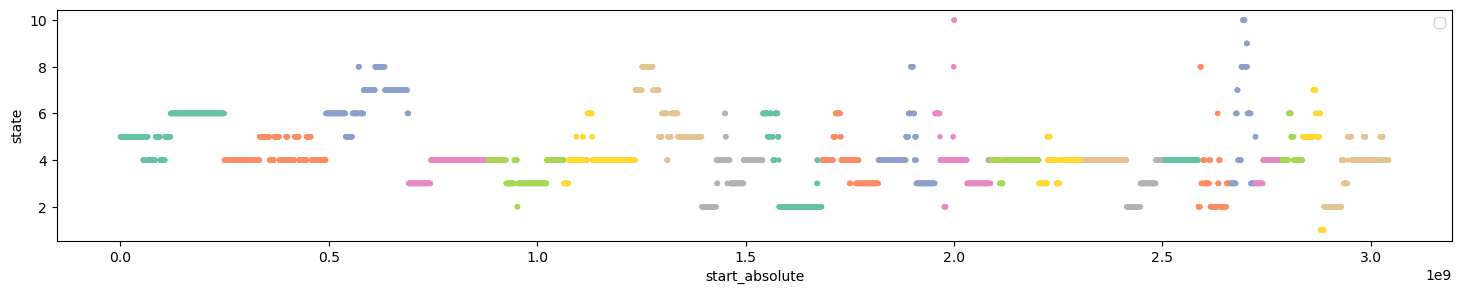

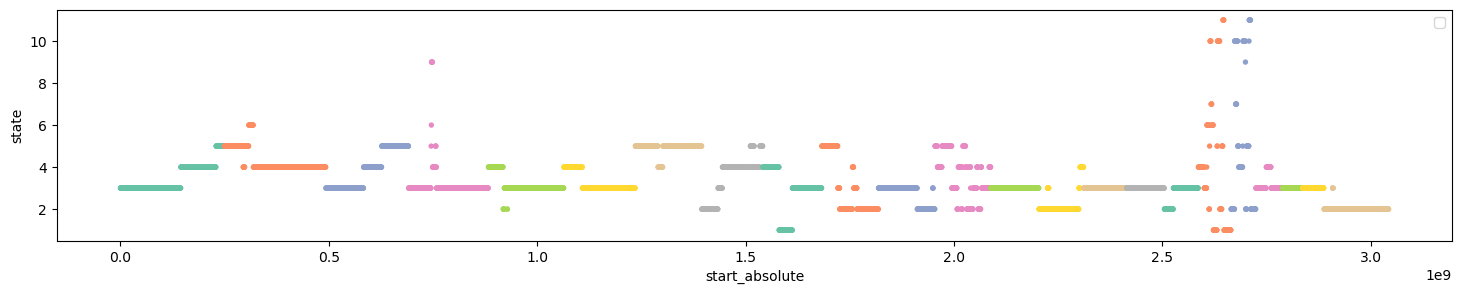

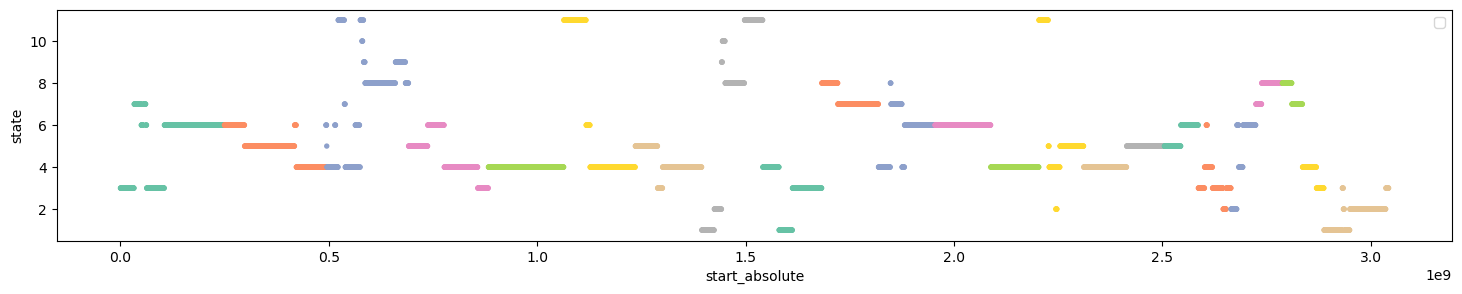

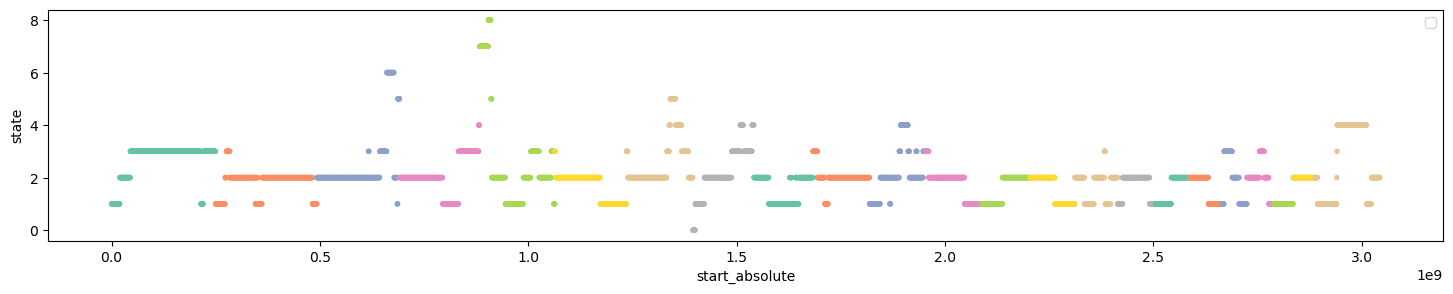

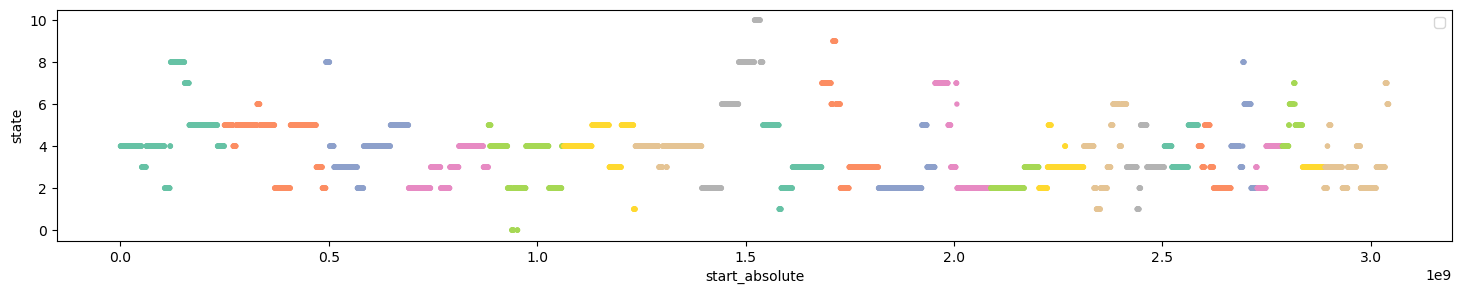

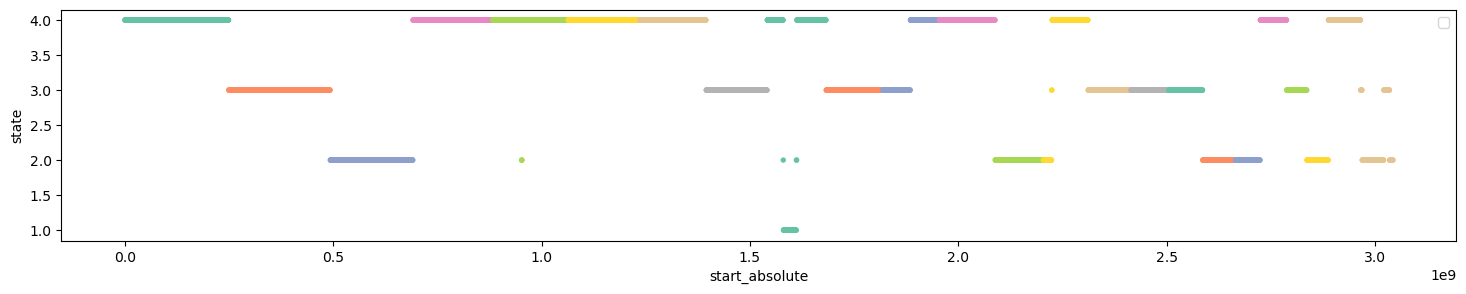

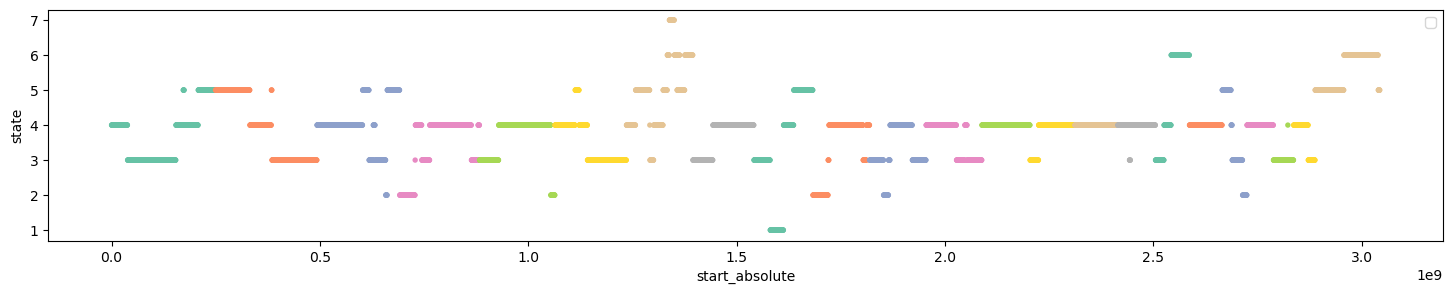

In [23]:
for tmp in clone_centroid['patient_clone'].unique():
	clone = clone_centroid[clone_centroid['patient_clone'] == tmp]
	plt.figure(figsize = (18,3))
	sns.scatterplot(x = 'start_absolute', y = 'state', data = clone, hue = 'chr', palette = 'Set2', linewidth = 0, s = 15)
	plt.legend([])

Simulate multiple clones starting from a base ploidy, and then decide the clone we want based on the number of segments we want to change

In [24]:
clone_centroid['minor_CN'] = [min(x,y) for x, y in zip(clone_centroid['Min'], clone_centroid['Maj'])]
clone_centroid['major_CN'] = [max(x,y) for x, y in zip(clone_centroid['Min'], clone_centroid['Maj'])]
clone_centroid['expected_BAF'] = clone_centroid['minor_CN'] / clone_centroid['state']
clone_centroid.rename({'state' : 'tot_CN'}, axis = 1, inplace = True, errors='ignore')
clone_centroid['cell_id'] = clone_centroid['patient_clone']
clone_centroid['clone'] = clone_centroid['patient_clone']
clone_centroid = clone_centroid[['chr', 'start', 'end', 'tot_CN', 'minor_CN', 'major_CN', 'expected_BAF', 'cell_id', 'clone']].copy()


In [25]:
ploidy_reads = 100
outliers_perc = 0

In [26]:
current_output = f"{output_directory}/dispersion_reads_grid_{outliers_perc}outliers/"
os.makedirs(current_output, exist_ok=True)

In [29]:
!pwd

/Users/lucrezia/Library/CloudStorage/OneDrive-UniversityCollegeLondon/postdoc/funnel_data


In [31]:
# norm_data = norm_data[norm_data['cor_gc_shifted'] > 20]
file = open(f'{package_dir}/auxiliary_data/res_NBFit_zeroState_13112023.pkl','rb')
res = pickle.load(file)
file.close()

ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'

In [27]:
cells_profiles = []

for d in [0.01,0.1, 0.2]:
	for r in [50,100,150]:
		current_cells_profiles = generate_cells_observations(clone_centroid.copy(), 
			reads_ploidy = r, 
			# reads_per_copy = 10,
			SNP_reads_ploidy = 40,
			nb_dispersion = d, 
			outlier_perc = outliers_perc,
			zero_mle_model=res)
		current_cells_profiles['cell_id'] = current_cells_profiles['cell_id'] + f'_d{d}_r{r}'
		current_cells_profiles = convert_chr_to_int(current_cells_profiles)
		current_cells_profiles = compute_absolute_start(current_cells_profiles)
		current_cells_profiles['NB_disp'] = d
		current_cells_profiles['ploidy_reads'] = r
		cells_profiles.append(current_cells_profiles)
cells_profiles = pd.concat(cells_profiles)

TypeError: generate_cells_observations() missing 1 required positional argument: 'zero_mle_model'

In [165]:
cells_profiles['library_size'] = cells_profiles.groupby('cell_id')['total_reads'].transform('sum')
cells_profiles['cor_gc_shifted'] = cells_profiles['total_reads'].copy()

In [172]:
cells_profiles

,chr,start,end,tot_CN,minor_CN,major_CN,expected_BAF,cell_id,clone,NB_mean,...,notmirrored_BAF,chr_from,start_absolute,NB_disp,ploidy_reads,library_size,cor_gc_shifted,state,minor_allele,totalcounts
60870,1,1,500000.0,4,0,4,0.000000,SA604_I_d0.01_r50,SA604_I,44.107098,...,0.000000,0.000000e+00,1.000000e+00,0.01,50,305226,43,4.534418,0,22
60871,1,500001,1000000.0,4,0,4,0.000000,SA604_I_d0.01_r50,SA604_I,44.107098,...,0.000000,0.000000e+00,5.000010e+05,0.01,50,305226,48,4.534418,0,27
60872,1,1000001,1500000.0,4,0,4,0.000000,SA604_I_d0.01_r50,SA604_I,44.107098,...,0.000000,0.000000e+00,1.000001e+06,0.01,50,305226,43,4.534418,0,47
60873,1,1500001,2000000.0,4,0,4,0.000000,SA604_I_d0.01_r50,SA604_I,44.107098,...,0.000000,0.000000e+00,1.500001e+06,0.01,50,305226,36,4.534418,0,17
60874,1,2000001,2500000.0,4,0,4,0.000000,SA604_I_d0.01_r50,SA604_I,44.107098,...,0.000000,0.000000e+00,2.000001e+06,0.01,50,305226,30,4.534418,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515658,23,153000001,153500000.0,3,1,2,0.333333,SA1055_A_d0.2_r150,SA1055_A,116.050926,...,0.461538,2.888000e+09,3.041000e+09,0.20,150,915419,152,3.877608,6,13
1515659,23,153500001,154000000.0,3,1,2,0.333333,SA1055_A_d0.2_r150,SA1055_A,116.050926,...,0.303571,2.888000e+09,3.041500e+09,0.20,150,915419,86,3.877608,17,56
1515660,23,154000001,154500000.0,3,1,2,0.333333,SA1055_A_d0.2_r150,SA1055_A,116.050926,...,0.363636,2.888000e+09,3.042000e+09,0.20,150,915419,69,3.877608,4,11
1515661,23,154500001,155000000.0,3,1,2,0.333333,SA1055_A_d0.2_r150,SA1055_A,116.050926,...,0.333333,2.888000e+09,3.042500e+09,0.20,150,915419,119,3.877608,18,54


([], [])

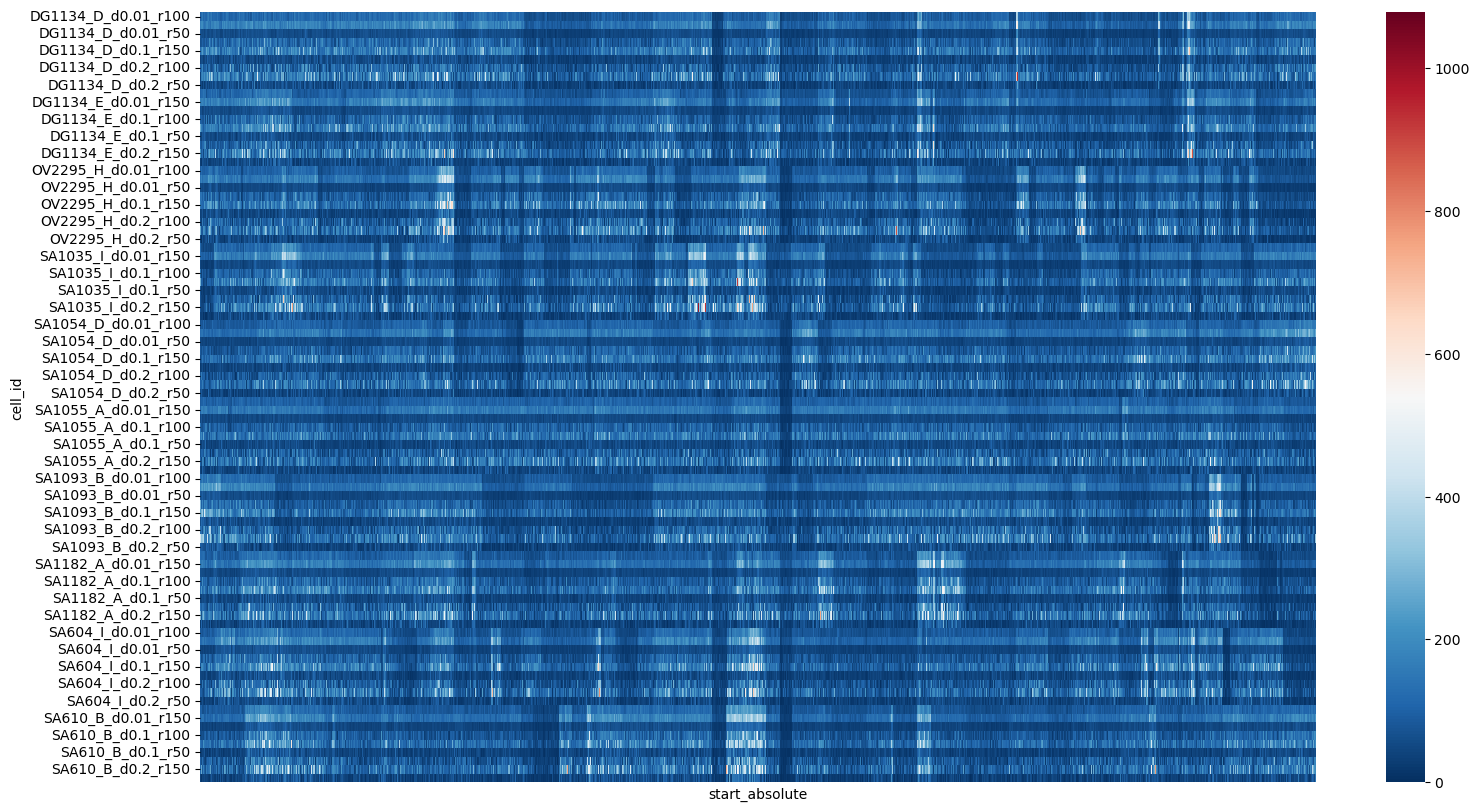

In [166]:
plt.figure(figsize = (18,10))
# g = sns.FacetGrid(cells_profiles, col = 'ploidy_reads', height=4, aspect=1)
sns.heatmap(cells_profiles.reset_index().pivot(index='cell_id', columns='start_absolute', values='total_reads'), annot = False, cmap = 'RdBu_r')
plt.xticks([])

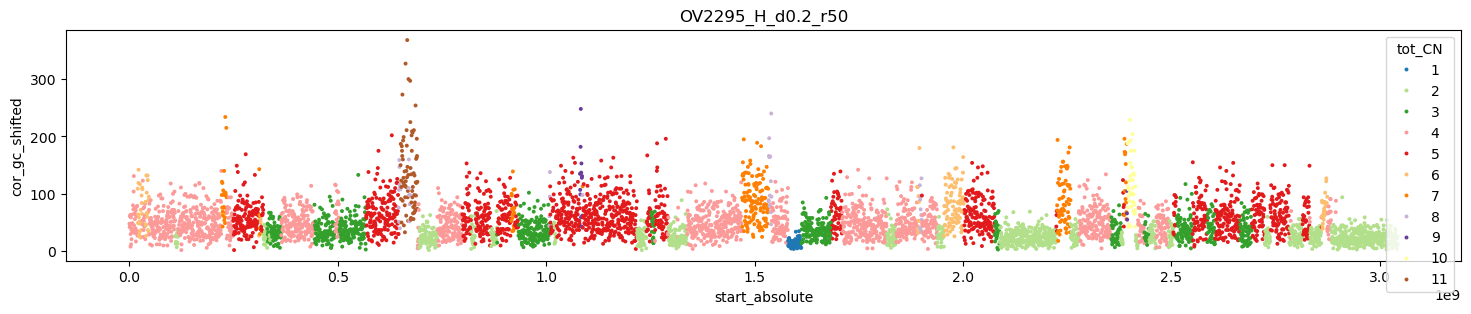

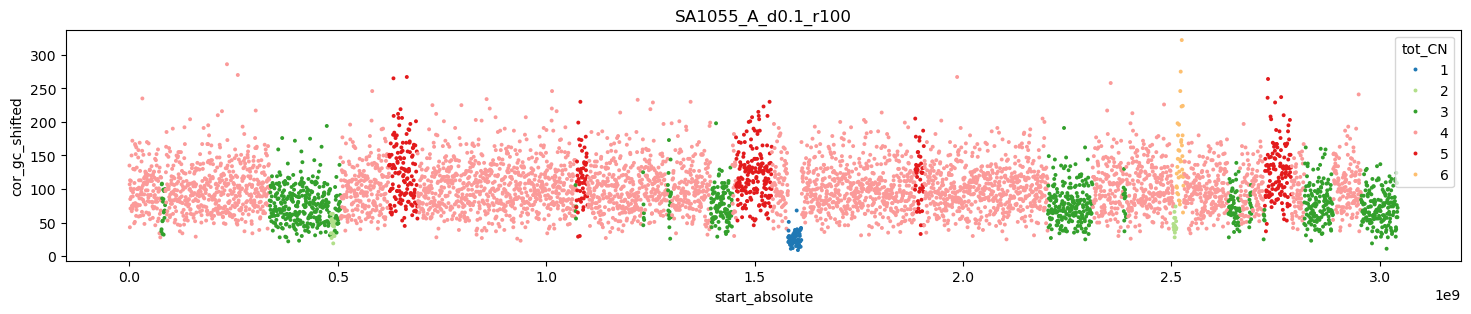

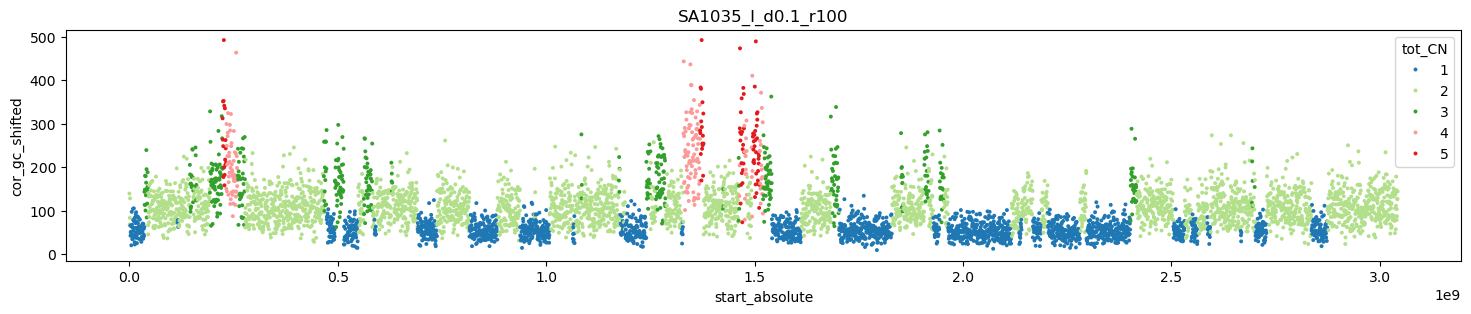

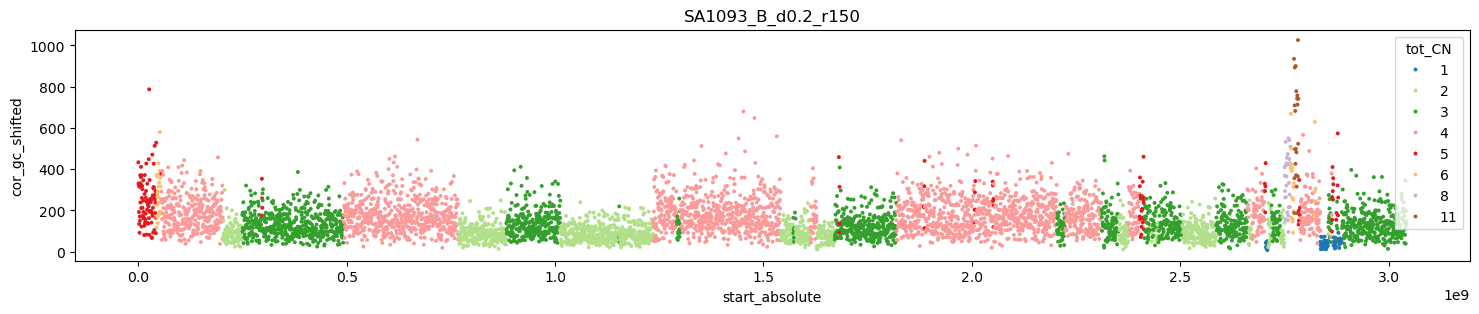

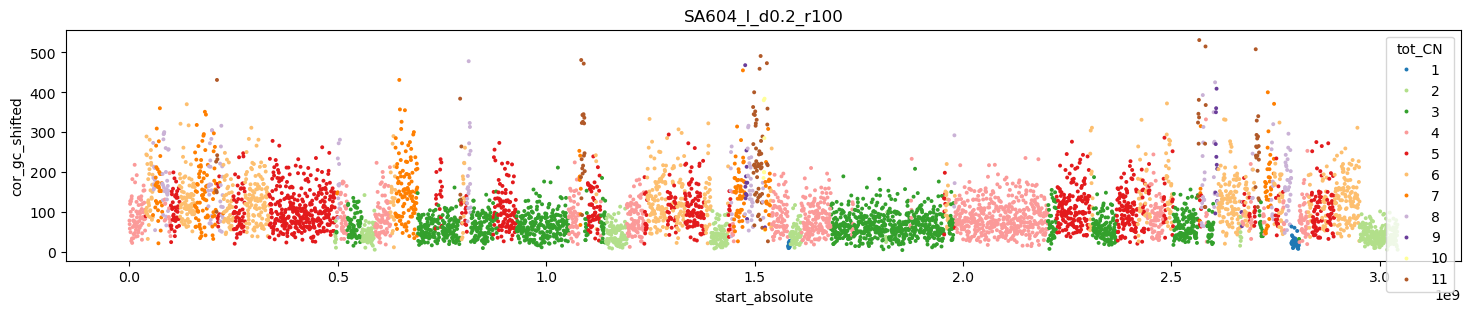

In [167]:
for c in cells_profiles['cell_id'].drop_duplicates().sample(5):
	plt.figure(figsize = (18,3))
	sns.scatterplot(x = 'start_absolute', y = 'cor_gc_shifted', hue = 'tot_CN', data = cells_profiles[cells_profiles['cell_id'] == c],
		s = 8, palette = color_mapping, linewidth = 0, alpha = 1 )
	plt.title(c)
	# plt.ylim(0,200)

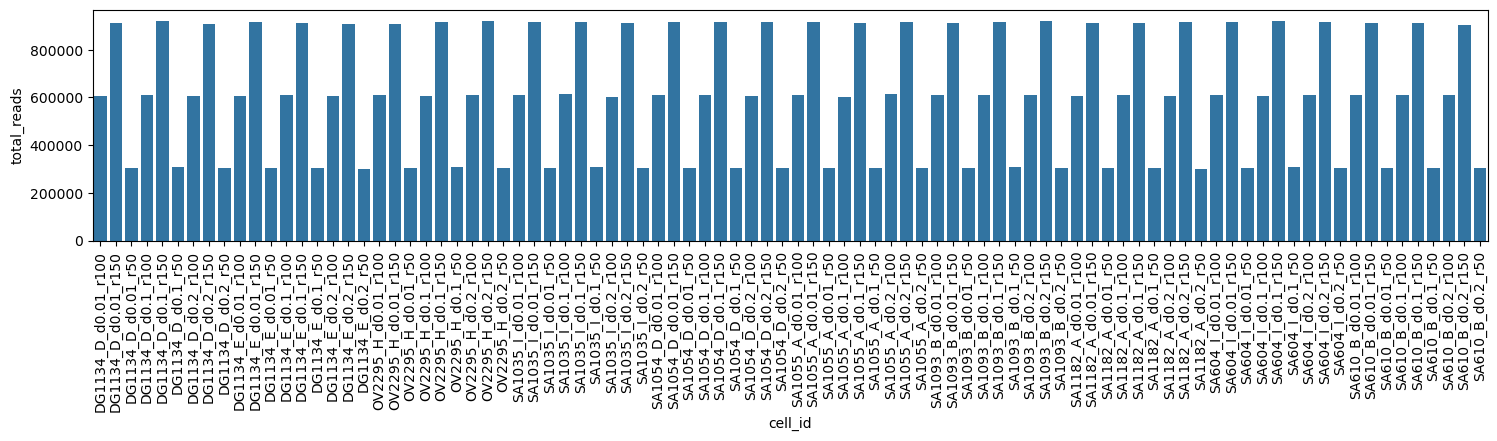

In [168]:
plt.figure(figsize = (18,3))
sns.barplot(cells_profiles.groupby('cell_id')['total_reads'].sum())
plt.xticks(rotation = 90);

In [169]:
hmmcopy_data = compute_data_hmmcopy(cells_profiles)
hmmcopy_data.to_csv(f'{current_output}/hmmcopy_input.csv.gz', index = False, compression='gzip')

[ 47.  48.  49.  46.  50.  94.  97.  98.  92. 100. 101.  91. 141. 146.
 147. 142. 138. 150. 153. 135. 148. 151.  45.  44.  89.  90.  95. 134.
 136. 139. 140. 132. 143.  43.  42.  85.  88.  86.  84.  87. 129. 130.
 131. 133. 125. 127.]


In [170]:
cells_profiles['state'] = cells_profiles.groupby('cell_id')['tot_CN'].transform('mean')
cells_profiles['minor_allele'] = cells_profiles['alt_reads'].copy()
cells_profiles['totalcounts'] = cells_profiles['SNP_reads'].astype(int)

In [171]:
cells_profiles.to_csv(f'{current_output}/nbhmm_input.csv.gz', index = False, compression='gzip')

In [178]:
# norm_data = cells_profiles.copy()
norm_data = pd.read_csv(f'{current_output}/nbhmm_input.csv')



# norm_data = norm_data[norm_data['cor_gc_shifted'] > 20]
file = open('./../lucrezia-dlp-cna/auxiliary_data/res_NBFit_zeroState_13112023.pkl','rb')
res = pickle.load(file)
file.close()


In [179]:
from parallelize_cells import *
test = test_hmm(norm_data, 2, 10, 3, 'NB', _zero_mle_model= res, jobs = 1) #

Progress: |------------------------------| 0.0% Complete [[2024-Oct-22 12:21:46]Started]

1
1


Progress: |██████████████████████████████| 100.0% Complete [[2024-Oct-22 12:22:16]Cell cell_1]


In [180]:
pickle.dump(test, open(f'{current_output}/nbhmm_output.pkl', 'wb'))

In [181]:
test = pickle.load(open(f'{current_output}/nbhmm_output.pkl', 'rb'))

In [182]:
tmp = test[0].copy()
tmp.columns
# test = [compute_ploidy_solution(current, dict_hmm_segmentation['cell_17'], n, plot=True) for n in range(1, 10)]


# tmp.sort_values(['cell_id', 'start_absolute'], inplace=True)

# tmp['minor_allele'] = tmp['alt_reads'].copy()
# tmp['totalcounts'] = tmp['SNP_reads'].astype(int)


In [183]:
# nanres = dict_hmm_segmentation['cell_1'].bic(norm_data['cor_gc_shifted'].values.reshape(-1,1))
# np.isnan(nanres)

Text(0.5, 1.0, 'HMM states step 2')

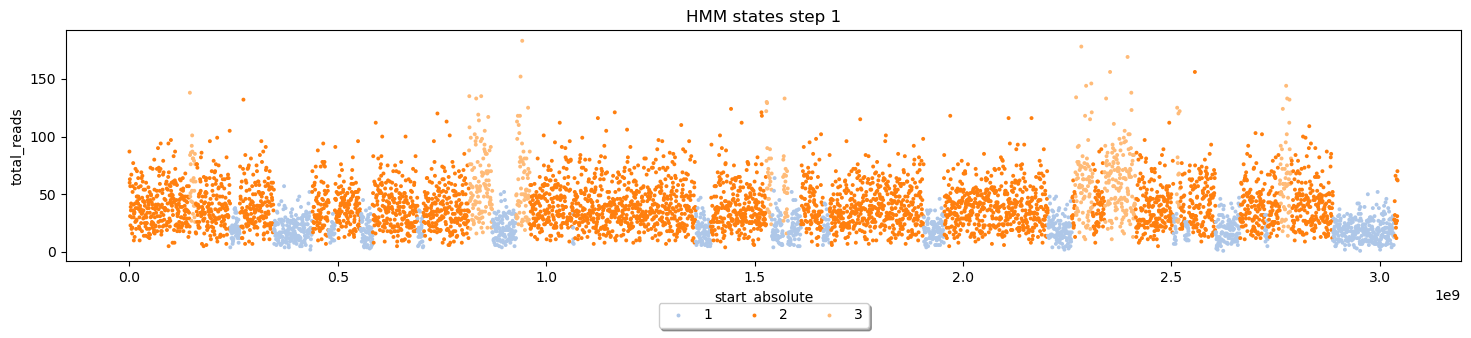

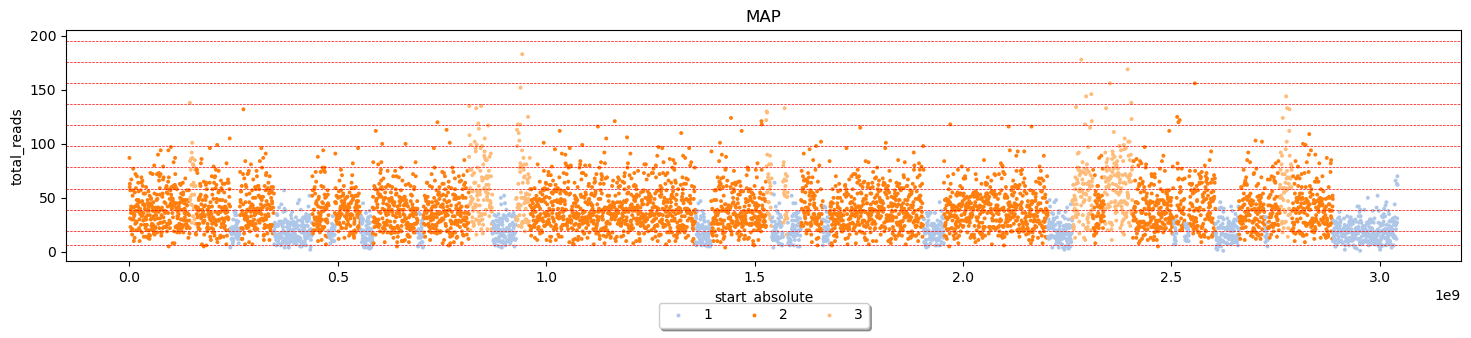

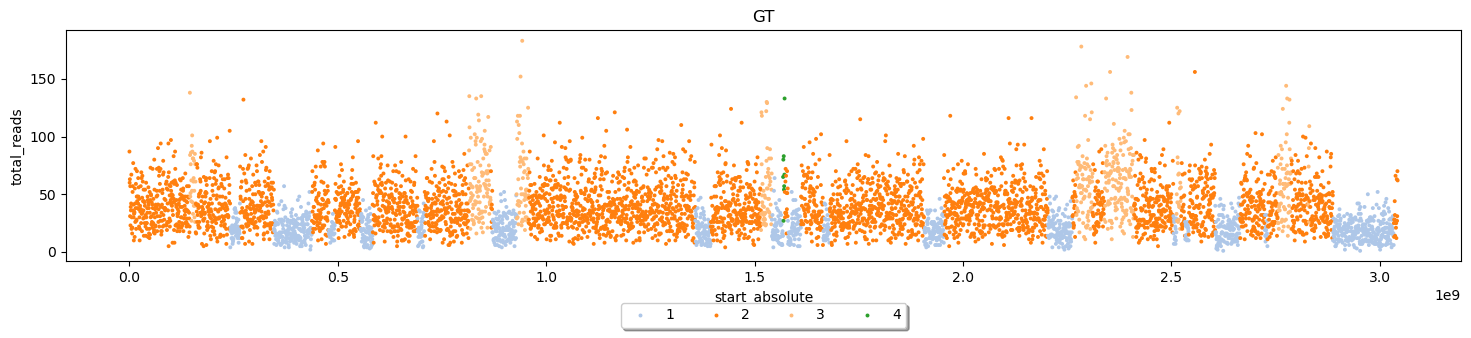

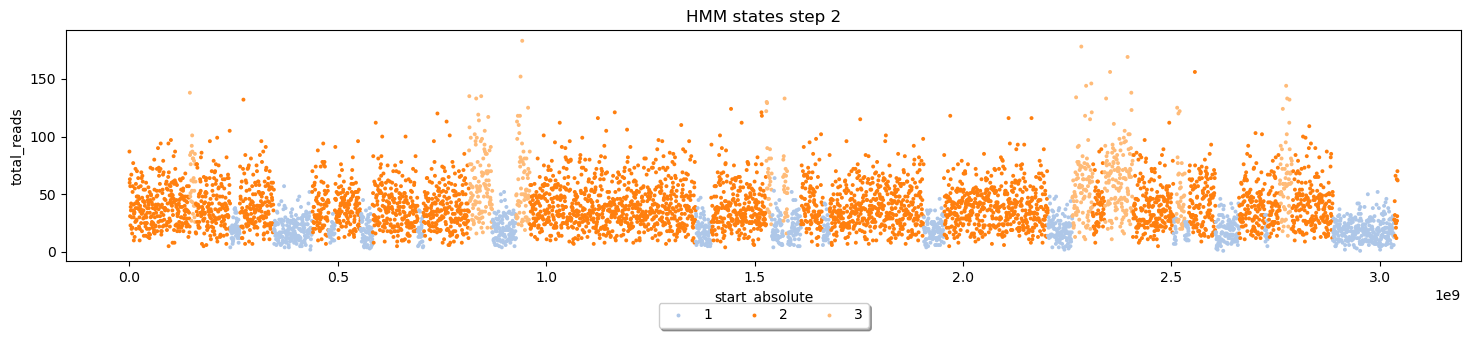

In [184]:
f,ax = plt.subplots(1,1, figsize = (18,3))
sns.scatterplot(x = 'start_absolute', y = 'total_reads', hue = 'hmm_states_step1', data = tmp,
	s = 8, palette = color_mapping, linewidth = 0 )
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=tmp['hmm_states_step1'].nunique())
plt.title('HMM states step 1')

f,ax = plt.subplots(1,1, figsize = (18,3))
sns.scatterplot(x = 'start_absolute', y = 'total_reads', hue = 'map_totcn_segment', data = tmp,
	s = 8, palette = color_mapping, linewidth = 0 )
for r in dict_hmm_ploidy['cell_1'].means_:
	ax.axhline(r, color = 'red', linestyle = '--', linewidth = 0.5)
	plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=tmp['map_totcn_segment'].nunique())
plt.title('MAP')


f,ax = plt.subplots(1,1, figsize = (18,3))
sns.scatterplot(x = 'start_absolute', y = 'total_reads', hue = 'tot_CN', data = tmp,
	s = 8, palette = color_mapping, linewidth = 0 )
plt.title('GT')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=tmp['tot_CN'].nunique())
f,ax = plt.subplots(1,1, figsize = (18,3))
sns.scatterplot(x = 'start_absolute', y = 'total_reads', hue = 'hmm_states', data = tmp,
	s = 8, palette = color_mapping, linewidth = 0 )
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=tmp['hmm_states'].nunique())
plt.title('HMM states step 2')

## Now run HMMCOPY

In [185]:
data = pd.read_csv(f'{current_output}/hmmcopy_input.csv')
data['modal_curve'] = 1

In [186]:
import shlex, shutil

In [187]:
vanres = hmmcopy_NBcomparison.main(args=shlex.split('-j 8'), inputdata=data)

> Parsing input arguments
> Creating temporary directory
> Reading input data
>> Cells discarded because not enough reads: 0
>> Average width of resulting genomic bins to be used: 499999.0
> Preparing mappability
> Correcting read counts and running hmmcopy
Progress: |██████████████████████████████| 100.0% Complete [[2024-Oct-22 12:23:13]Cell cell_1]
> Removing temporary directory


In [188]:
vanres = compute_absolute_start(vanres)
vanres = vanres.merge(data[['cell_id', 'tot_CN', 'chr', 'start']])

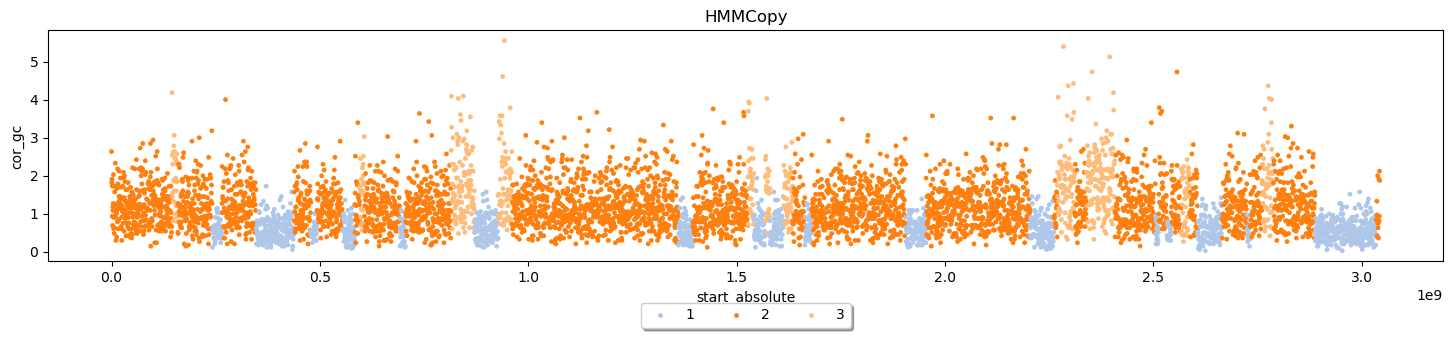

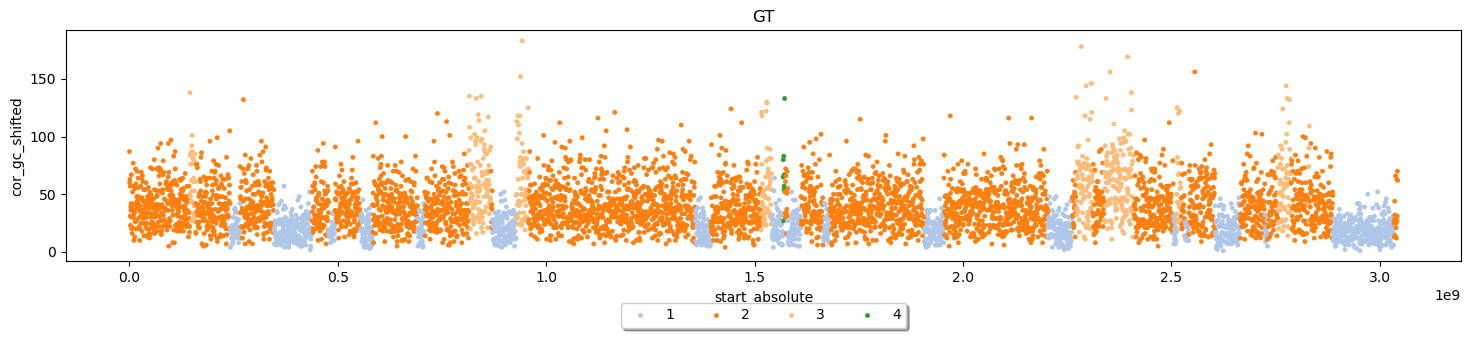

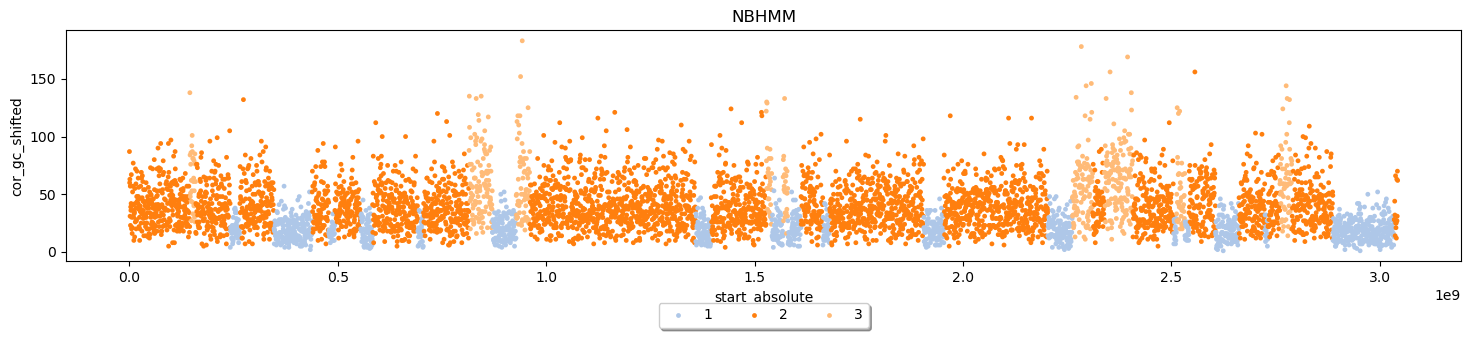

In [191]:
f,ax = plt.subplots(1,1, figsize = (18,3))
sns.scatterplot(x = 'start_absolute', y = 'cor_gc', hue = 'state', data = compute_absolute_start(vanres),
	s = 12, palette = color_mapping, linewidth = 0 )
plt.title('HMMCopy')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=vanres['state'].nunique())
f,ax = plt.subplots(1,1, figsize = (18,3))
sns.scatterplot(x = 'start_absolute', y = 'cor_gc_shifted', hue = 'tot_CN', data = tmp,
	s = 12, palette = color_mapping, linewidth = 0 )
plt.title('GT')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=tmp['tot_CN'].nunique())
f,ax = plt.subplots(1,1, figsize = (18,3))
sns.scatterplot(x = 'start_absolute', y = 'cor_gc_shifted', hue = 'hmm_states', data = tmp,
	s = 12, palette = color_mapping, linewidth = 0 )
plt.title('NBHMM')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=tmp['hmm_states'].nunique())
# for n in range(reads_per_copy, reads_per_copy*vanres['tot_CN'].max(), reads_per_copy):
# 	plt.axhline(n, color = 'black', linestyle = '--')
# inferred_reads_copy = int(np.ceil(final_results[tmp['map_totcn_segment'] == 3]['cor_gc_shifted'].mean() / 3))
# for n in range(inferred_reads_copy, inferred_reads_copy*vanres['tot_CN'].max(), inferred_reads_copy):
# 	plt.axhline(n, color = 'red', linestyle = '--')
# plt.axhline(inferred_reads_copy, color = 'red', linestyle = '--')

state
1    0.494099
2    0.473078
3    0.471511
Name: cor_gc, dtype: float64


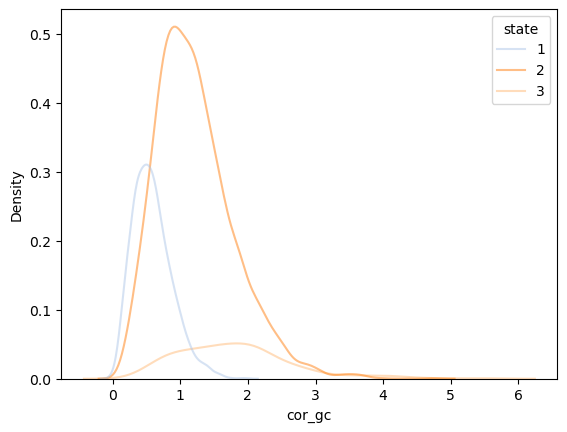

In [198]:
sns.kdeplot(data = vanres, x = 'cor_gc', alpha = 0.5, hue = 'state', palette = color_mapping)
print(vanres.groupby('state')['cor_gc'].std()/ vanres.groupby('state')['cor_gc'].mean())

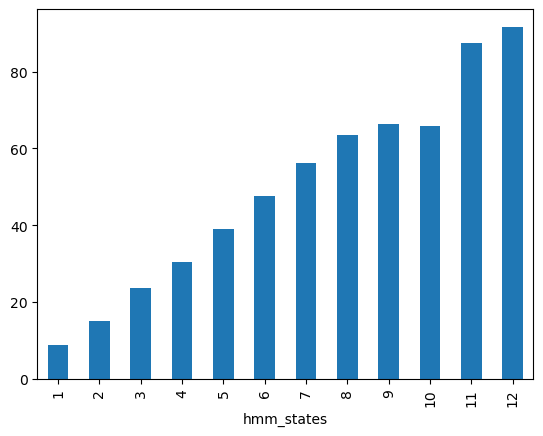

<Axes: xlabel='state'>

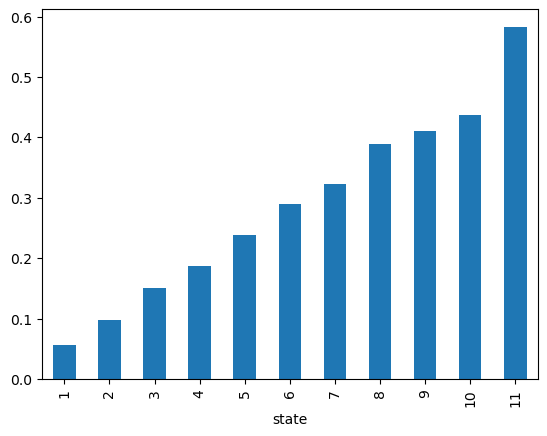

In [73]:
tmp.groupby('hmm_states')['cor_gc_shifted'].std().plot.bar()
plt.show()
vanres.groupby('state')['cor_gc'].std().plot.bar()

In [94]:
pickle.dump(vanres, open(f'{current_output}/hmmcopy_results.pkl', 'wb'))